# SPE homework 1
## imports and functions

In the cell below we grouped all the statistical formulas that we implemented in order to complete the exercises. In particular, the following are some observations that should clarify some choices in our code:

We used the `variance` given by this formula in order to hold exactly: $\hat\sigma_n^2=\dfrac{1}{n-1}\sum_{i=1}^{n}(X_i-\hat\mu_n)^2$
- this way there were no doubts because we used the formula in both cases when it was needed for precise results and not
- the `standard deviation` was set accordingly

The function that calculates the `confidence intervals given a quantile` distinguishes between two main cases accordingly to the size of the dataset:
- if the dataset is small (an arbitrary small $n=100$ was set as the threshold value) the binomial cumulative distribution function is used in order to find the smallest interval $[X_{(j)},X_{(k)}]$ that satisfies the formula $B_{n,p}(k-1)-B_{n,p}(j-1) \ge \gamma$ , where $\gamma$ is the confidence level
- if the dataset is large enough, an asymptotic approximation method is used for the calculation of the confidence interval ends $j$ and $k$:
    - $j \approx \lfloor np -\eta\sqrt{np(1-p)}\rfloor$
    - $k \approx \lceil np +\eta\sqrt{np(1-p)}\rceil + 1$
    
The remaining functions in this section are self explanatory enough.

In [15]:
from pandas import read_csv
import numpy as np
from matplotlib import pyplot as plt
from numpy import mean, min, max, median, quantile
from scipy.stats import binom, norm, t as student
from math import sqrt, pow, floor, ceil, exp

# define corrected functions for std and variance
def variance(values):
    return np.var(values, ddof=1)
def std(values):
    return np.std(values, ddof=1)

def quantile_confidence(values, q, confidence):
    # return tuple (lower, upper) of values
    values = sorted(values)
    n = len(values)
    if n > 100:
        # approximate
        z = norm.ppf((1+confidence)/2)
        j = floor(n*q-z*sqrt(n*q*(1-q)))
        k = ceil(n*q+z*sqrt(n*q*(1-q)))+1
        return (values[j], values[k], confidence)

    # with n <= 100, use binom cdf formula
    results = []
    binoms = [binom.cdf(i, n, q) for i in range(0, n)]
    for j in range(1, n):
        for k in range(j, n):
            val = binoms[k] - binoms[j]
            if val >= confidence:
                results.append((j, k, val))

    # sort by smallest interval and highest confidence value
    results = sorted(results, key=lambda x: (x[1]-x[0], -x[2]))
    best = results[0]
    return (values[best[0]], values[best[1]])

def mean_confidence_asymptotic(values, confidence):
    # when variables iid and high n
    n = len(values)
    z = norm.ppf((1+confidence)/2)
    s = std(values)
    m = mean(values)
    j = m - z*s/sqrt(n)
    k = m + z*s/sqrt(n)
    return (j, k)

def CoV(values):
    # Coeff of variation (not defined on heavy tailed sets, because variance=>inf)
    return std(values)/mean(values)

def MAD(values):
    # mean absolute deviation, always defined
    n = len(values)
    m = mean(values)
    return sum([abs(x-m) for x in values])/n

def lorenz_gap(values):
    # always defined, the best
    return MAD(values)/(2*mean(values))

def JFI(values):
    # Jain Fairness Index (same problems as CoV?)
    return 1/(1+pow(CoV(values), 2))

def bootstrap(values, confidence, func, r0=25):
    R = ceil(2*r0/(1-confidence))
    n = len(values)
    Tvs = []
    for r in range(R):
        V = np.random.choice(values, size=(n,))
        Tv = func(V)
        Tvs.append(Tv)
    Tvs = sorted(Tvs)
    interval = (Tvs[r0], Tvs[R-r0-1])
    low = 0
    high = 0
    for tv in Tvs:
        if tv < interval[0]:
            low += 1
        if tv > interval[1]:
            high += 1
    return interval

def success_probability_confidence_normal(values, confidence):
    n = len(values)
    z = sum(values)
    eta = norm.ppf((1+confidence)/2)
    lower = z/n - eta/n * sqrt(z* (1 - z/n))
    upper = z/n + eta/n * sqrt(z* (1 - z/n))
    return (lower, upper)
    
def success_probability_confidence_three(values, confidence):
    n = len(values)
    lower = 0
    upper = 1 - pow(((1-confidence)/2), 1/n)
    return (lower, upper)

## Import data

In [16]:
data = 'data'
data_ex1 = read_csv(f'{data}\\data_ex1.csv', header=None)
data_ex2 = read_csv(f'{data}\\data_ex2.csv', header=None)
data_ex3 = read_csv(f'{data}\\data_ex3.csv', header=None)
data_ex4 = read_csv(f'{data}\\data_ex4.csv', header=None)
data_ex5 = read_csv(f'{data}\\data_ex5.csv', header=None)

## Exercise 1

1. To compute the confidence interval for the mean, knowing that the datasamples were iid, we used the formula of Theorem 2.1. In particular, given the large number of elements the right formula to use was the approximation, where $p$ is 0.5 for the median and $\eta$ is the quantile of the normal distribuition in $\dfrac{1+\gamma}{2}$ (we computed it but it could be approximated as 1.96 for $\gamma$= 0.95).
    - $j \approx \lfloor np -\eta\sqrt{np(1-p)}\rfloor$
    - $k \approx \lceil np +\eta\sqrt{np(1-p)}\rceil + 1$

2. For the mean, knowing the data samples to be iid and large in number, we used the CI for the mean in the asymptotic case described in Theorem 2.2. $$\hat\sigma_n=\pm\eta\dfrac{s_n}{\sqrt{n}}$$

In [17]:
values = data_ex1.to_numpy()[:, 0]
values = sorted(values)
print("Median:", median(values))
interval = quantile_confidence(values, 0.5, 0.95)
print(f"Median CI at 0.95: [{interval[0]} , {interval[1]}]")

# 1000 iid values, no heavy tail => asymptotic
print(f"Mean: {mean(values)}")
interval = mean_confidence_asymptotic(values, 0.95)
print(f"Mean CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = mean_confidence_asymptotic(values, 0.99)
print(f"Mean CI at 0.99: [{interval[0]} , {interval[1]}]")

Median: 0.40319100366316096
Median CI at 0.95: [0.384475528575523 , 0.4171819583272271]
Mean: 0.41020458058272363
Mean CI at 0.95: [0.398868829144219 , 0.42154033202122826]
Mean CI at 0.99: [0.3953068778885086 , 0.42510228327693866]


## Exercise 2
1. Given the datasamples are iid and the distribution looks normal, we used the asymptotic method to calculate the CI for the mean.

2. We didn't expect the percentage of means inside the CI to be as low as 67%. Running the same computations using other rows for the reference CI we realized that the first row is not a good representation of the entire dataset. The first row doesn't have heavy tails, its values are simply higher on average than the dataset mean.

In [18]:
rows = data_ex2.to_numpy()
# 200 values => asymptotic again
values = rows[0]
print(f"Mean: {mean(values)}")
interval = mean_confidence_asymptotic(values, 0.95)
print(f"Mean CI at 0.95: [{interval[0]} , {interval[1]}]")

inside = 0
for i in range(1, len(rows)):
    m = mean(rows[i])
    if m >= interval[0] and m <= interval[1]:
        inside += 1

print(f"Ratio of rows with mean inside CI 0.95: {inside/(len(rows)-1)}")

Mean: 3.175048214082969
Mean CI at 0.95: [2.9374928534666043 , 3.4126035746993337]
Ratio of rows with mean inside CI 0.95: 0.6693333333333333


## Exercise 3
1. For the CoV, JFI and Lorenz curve gap we used the functions defined above.

2. nonsesa

3. We implemented the boostrap algorithm from the slides for generic metric and confidence level.

4. Using the boostrap method we expected to see a relevant underestimation of the CI, but the values are almost identical to the asymptotic results.

CoV: 1.001469136252603
Lorenz gap: 0.36230444707595705
Jain FI: 0.49926597146344925


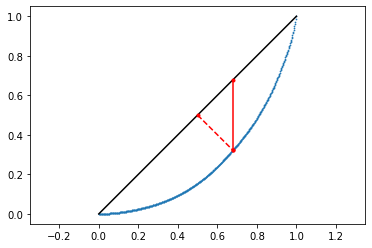

Lorenz gap: 0.36230444707595705
Bootstrap Lorenz gap CI at 0.95: [0.3401686049588147 , 0.38424687163579113]
Bootstrap Lorenz gap CI at 0.99: [0.33388479044568353 , 0.39010872383277506]

Jain FI: 0.49926597146344925
Bootstrap Jain FI CI at 0.95: [0.4620335271883287 , 0.542567595464761]
Bootstrap Jain FI CI at 0.99: [0.4437940222828429 , 0.5593172761481044]

Mean: 4.084097581606042
Bootstrap mean CI at 0.95: [3.7233474145018928 , 4.433721706258104]
Bootstrap mean CI at 0.99: [3.6162183234234435 , 4.576528849845521]

Std: 4.090097677422348
Bootstrap std CI at 0.95: [3.5652962164134867 , 4.652286787832505]
Bootstrap std CI at 0.99: [3.426750947116546 , 4.768749862498463]

Asymptotic mean CI at 0.95: [3.7255913008639814 , 4.442603862348103]
Asymptotic mean CI at 0.99: [3.612940463043766 , 4.555254700168319]



In [26]:
values = data_ex3.to_numpy()[:,0]
values = sorted(values)

print(f"CoV: {CoV(values)}")
print(f"Lorenz gap: {lorenz_gap(values)}")
print(f"Jain FI: {JFI(values)}")

# plot lorenz
n = len(values)
X = []
Y = []
tot = sum(values)
cum_sum = np.cumsum(values)
for i in np.arange(0, n, 1):
    X.append(i/n)
    Y.append(cum_sum[i]/tot)

plt.scatter(X, Y, s=0.5)
# find intersection point calculating slope of line from (0.5,0.5) to each point
# of the second parth of the curve, find the closest to -1
X = X[ceil(len(X)/2+1):]
Y = Y[ceil(len(Y)/2+1):]
intersection_point = np.argmin([abs(-1 - (0.5-Y[i])/(0.5-X[i])) for i in range(len(X))])
x_i = X[intersection_point]
y_i = Y[intersection_point]
plt.axis('equal')
plt.plot([0,1], [0,1], 'k-')
plt.plot([0.5, x_i], [0.5, y_i], '.r--')
plt.plot([x_i, x_i], [y_i, x_i], '.r-')
plt.show()

print(f"Lorenz gap: {lorenz_gap(values)}")
interval = bootstrap(values, 0.95, lorenz_gap)
print(f"Bootstrap Lorenz gap CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = bootstrap(values, 0.99, lorenz_gap)
print(f"Bootstrap Lorenz gap CI at 0.99: [{interval[0]} , {interval[1]}]\n")

print(f"Jain FI: {JFI(values)}")
interval = bootstrap(values, 0.95, JFI)
print(f"Bootstrap Jain FI CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = bootstrap(values, 0.99, JFI)
print(f"Bootstrap Jain FI CI at 0.99: [{interval[0]} , {interval[1]}]\n")

print(f"Mean: {mean(values)}")
interval = bootstrap(values, 0.95, mean)
print(f"Bootstrap mean CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = bootstrap(values, 0.99, mean)
print(f"Bootstrap mean CI at 0.99: [{interval[0]} , {interval[1]}]\n")

print(f"Std: {std(values)}")
interval = bootstrap(values, 0.95, std)
print(f"Bootstrap std CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = bootstrap(values, 0.99, std)
print(f"Bootstrap std CI at 0.99: [{interval[0]} , {interval[1]}]\n")

# compare bootstrap mean with asymptotic mean
interval = mean_confidence_asymptotic(values, 0.95)
print(f"Asymptotic mean CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = mean_confidence_asymptotic(values, 0.99)
print(f"Asymptotic mean CI at 0.99: [{interval[0]} , {interval[1]}]\n")

# bootstrap has smaller interval

## Exercise 4
1. We used the bootstrap function implemented above.
2. Confronting the values of the CI obtained with the bootstrap method and the asymptotic one we can show what we already expected: the bootstrap method tends to underestimate the interval. For both values of confidence the interval computed with the bootstrap method is definitely smaller that the one computed with the asymptotic formulas. Plotting the data revealed that the distribution is heavy tailed.
3. Transforming the data using a logarithm yields a better distribution, as seen in the second plot. Even after the transformation the bootstrap interval is sligtly smaller in both cases than the asymptotic one. Once re-transformed, the intervals with both methods are more consistent with the original data and less biased.

Mean CI at 0.95 using bootstrap: [118.17569562209829 , 12067.115318198863]
Mean CI at 0.99 using bootstrap: [60.16170471359971 , 15800.159546215484]

Mean CI at 0.95 using asymptotic: [-3226.3420437613004 , 11612.994704202103]
Mean CI at 0.99 using asymptotic: [-5557.770818027488 , 13944.42347846829]



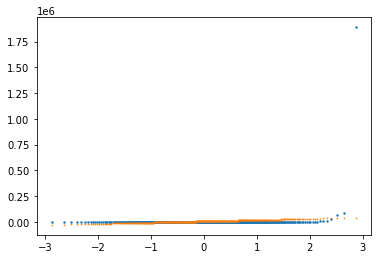

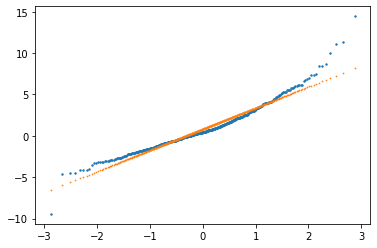

Mean CI at 0.95 using bootstrap: [0.5908929706002223 , 1.065192026804305], re-transformed: [1.8056000434771031 , 2.9013960763861637]
Mean CI at 0.99 using bootstrap: [0.5184435783728581 , 1.118666339634423], re-transformed: [1.6794117417433778 , 3.0607694531559235]

Mean CI at 0.95 using asymptotic: [0.5924332420947909 , 1.0491151025472925], re-transformed: [1.8083833006902783 , 2.8551235083706876]
Mean CI at 0.99 using asymptotic: [0.5206833217157347 , 1.1208650229263486], re-transformed: [1.6831774085012328 , 3.0675065194365163]



In [20]:
values = data_ex4.to_numpy()[:,0]
values = sorted(values)

# compare bootstrap and asymptotic
interval = bootstrap(values, 0.95, mean)
print(f"Mean CI at 0.95 using bootstrap: [{interval[0]} , {interval[1]}]")
interval = bootstrap(values, 0.99, mean)
print(f"Mean CI at 0.99 using bootstrap: [{interval[0]} , {interval[1]}]\n")

interval = mean_confidence_asymptotic(values, 0.95)
print(f"Mean CI at 0.95 using asymptotic: [{interval[0]} , {interval[1]}]")
interval = mean_confidence_asymptotic(values, 0.99)
print(f"Mean CI at 0.99 using asymptotic: [{interval[0]} , {interval[1]}]\n")

#plot QQ
X = []
Y = []
n = len(values)
for i in np.arange(0,n,1):
    X.append(norm.ppf((i+1)/(n+1)))
    Y.append(values[i])
X = np.array(X)
Y = np.array(Y)
m, b = np.polyfit(X, Y, 1)
plt.scatter(X, Y, s=2)
plt.scatter(X, m*X + b, s=0.5)
plt.show()

# log transform
Y_log = np.log(values)
m, b = np.polyfit(X, Y_log, 1)
plt.scatter(X, Y_log, s=2)
plt.scatter(X, m*X + b, s=0.5)
plt.show()

# compare bootstrap and asymptotic on log data
values = np.log(values)
interval = bootstrap(values, 0.95, mean)
print(f"Mean CI at 0.95 using bootstrap: [{interval[0]} , {interval[1]}], re-transformed: [{exp(interval[0])} , {exp(interval[1])}]")
interval = bootstrap(values, 0.99, mean)
print(f"Mean CI at 0.99 using bootstrap: [{interval[0]} , {interval[1]}], re-transformed: [{exp(interval[0])} , {exp(interval[1])}]\n")

interval = mean_confidence_asymptotic(values, 0.95)
print(f"Mean CI at 0.95 using asymptotic: [{interval[0]} , {interval[1]}], re-transformed: [{exp(interval[0])} , {exp(interval[1])}]")
interval = mean_confidence_asymptotic(values, 0.99)
print(f"Mean CI at 0.99 using asymptotic: [{interval[0]} , {interval[1]}], re-transformed: [{exp(interval[0])} , {exp(interval[1])}]\n")


## Exercise 5
1. We calculated the probability by using the mean of the values. There are 125>=6 successes and 875>=6 failures, therefore we can approximate the CI using the normal approximation from Theorem 2.4:
    - $L(z) \approx \dfrac{z}{n}-\dfrac{\eta}{n}\sqrt{z\bigg(1-\dfrac{z}{n}\bigg)}$
    - $U(z) \approx \dfrac{z}{n}+\dfrac{\eta}{n}\sqrt{z\bigg(1-\dfrac{z}{n}\bigg)}$
2. There are 0 successes in the first 15 cases. The resulting probability is 0 and we have to use the rule of three for the CI estimation. Since the left boundary is 0, we only need the right boundary from formula 2.28:
$$p_0(n)=1-\bigg(\dfrac{1-\gamma}{2}\bigg)^\dfrac{1}{n}$$

In [21]:
values = data_ex5.to_numpy()[0]

# success = 1, failure = 0
n_success = sum(values)
print(f"Probability of success (mean): {mean(values)}")
interval = success_probability_confidence_normal(values, 0.95)
print(f"Probability CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = success_probability_confidence_normal(values, 0.99)
print(f"Probability CI at 0.99: [{interval[0]} , {interval[1]}]")

# using only the first 15
values = data_ex5.to_numpy()[0][:15]
n_success = sum(values)
print(f"Probability of success (mean): {mean(values)}")
interval = success_probability_confidence_three(values, 0.95)
print(f"Probability CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = success_probability_confidence_three(values, 0.99)
print(f"Probability CI at 0.99: [{interval[0]} , {interval[1]}]")

There are 125>=6 successes and 875>=6 failures. We can approximate using the normal approximation
Probability of success (mean): 0.125
Probability CI at 0.95: [0.10450220600861107 , 0.14549779399138893]
Probability CI at 0.99: [0.0980613323318191 , 0.1519386676681809]
There are 0 successes: we have to use the rule of three
Probability of success (mean): 0.0
Probability CI at 0.95: [0 , 0.21801936091053398]
Probability CI at 0.99: [0 , 0.2975781698474812]
